# Transfer learning with TensorFlow PArt 1: Feature Extraction

While one appraoch to improving models is to continue to tweak parameters, a quick and effective alterate method is **transfer learning** This takes the weights and biases learned in an existing model, trained on similar data, and applies it to the new model.

Main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

Sometimes the data learned by source models can be on millions of pieces of data such as *ImageNet*.

## In this Notebook:
* Introduction to transfer learning (improve on models from 03)
* Use a smaller dataset to experiment faster
* Build a transfer learning feature extraction model using TF Hub
* Introduce, and Compare model results using TensorBoard

In [2]:
# Confirm GPU usage
!nvidia-smi

Tue Jun 28 17:27:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Transfer learning with **TensorFlow Hub**

By utilizing transfer learning we are able to take weights and biases from similar neural networks, or neural network layers and use them as starting points for training on our own data.

This allows us to have good results with less data than we would normally have to train on.

[TensorFlow Hub](https://tfhub.dev/) is a repository for many trained models and their components.

## Downloading and Understanding the Data

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-28 17:27:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   280MB/s    in 0.6s    

2022-06-28 17:27:29 (280 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Review the directories and files
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Preparing / Loading the data

In [5]:
# Set data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

datagen = ImageDataGenerator(rescale=1./255)

print("Training Images")

train_data_10_percent = datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

test_data = datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SHAPE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')


Training Images
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


##  Setting up the Callbacks

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* [Experiment tracking with TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [Model checkpointing](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.


First we will focus on the TensorBoard callback. It's main functionality is toi save a model's training performance to a `log_dir`. Logs are by default recorded every epoch

In [6]:
# Create TensorBoard callback (creating a function because we need to call this for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

This function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`. We provide the directory name and the experiment name.

## Creating models using TensorFlow Hub
We are going to create a model, not from scratch, but from pulling layers from TensorFlow Hub.

The two models we will use are:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) - state of the art computer vision model architecture from 2016
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - state of the art computer vision architecture from 2019

Finding models on TensorFlow Hub:
1. Go to tfhub.dev.
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on.
 * Note: "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
5. The models listed are all models which could potentially be used for your problem.

**Types of Transfer Learning**

1. *"As is" transfer learning* - when you take a pretrained model as it is and apply it to your task without any changes.

* For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

 * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

2. *Feature extraction transfer learning* - when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

* For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

 * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on. 
3. *Fine-tuning transfer learning* - when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

* This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

* A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).
After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

🤔 Question: Why train only the top 2-3 layers in feature extraction?

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

We will compare EfficientNet and ResNet against each other. This is common practice.

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and create a Keras Sequential model with it.

  Args:
    model_url (str): a tf hub feature extraction url.
    num_classes (int): Number of neurons in output layer. Should be equal to number of target classes. Default 10

  Returns: 
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, 
                                            activation='softmax',
                                            name='output_layer')
  ])

  return model

In [9]:
# Create model (ResNet)
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Fit the model with callback to track model performance
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20220628-172742
Epoch 1/5
24/24 [==============================] - 32s 776ms/step - loss: 1.9287 - accuracy: 0.3507 - val_loss: 1.2206 - val_accuracy: 0.6112
Epoch 2/5
24/24 [==============================] - 17s 720ms/step - loss: 0.9010 - accuracy: 0.7307 - val_loss: 0.8600 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 16s 688ms/step - loss: 0.6192 - accuracy: 0.8173 - val_loss: 0.7528 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 16s 687ms/step - loss: 0.4656 - accuracy: 0.8720 - val_loss: 0.7197 - val_accuracy: 0.7568
Epoch 5/5
24/24 [==============================] - 16s 687ms/step - loss: 0.3752 - accuracy: 0.9133 - val_loss: 0.6776 - val_accuracy: 0.7804


After only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our `plot_loss_curves` function.

In [12]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

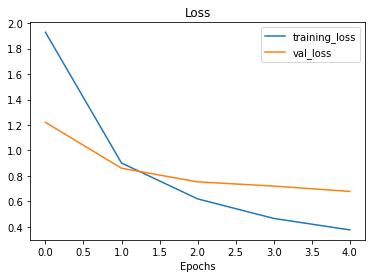

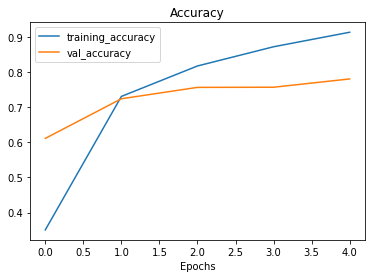

In [13]:
plot_loss_curves(resnet_history)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


**Note:** We can see that the feature extraction layer that we pulled from TF Hub has 23,564,800 parameters that were prelearned. Because we 'froze' the weights by setting `trainable=false` these are not updated.

Instead we train only the 20,490 parameters from the output layer. 

In [20]:
# Perform the same as above with the EfficientNetB0
# Create model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetB0')])
                                  


Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20220628-173315
Epoch 1/5
24/24 [==============================] - 24s 704ms/step - loss: 1.7808 - accuracy: 0.4947 - val_loss: 1.2466 - val_accuracy: 0.7552
Epoch 2/5
24/24 [==============================] - 15s 662ms/step - loss: 1.0259 - accuracy: 0.8013 - val_loss: 0.8409 - val_accuracy: 0.8256
Epoch 3/5
24/24 [==============================] - 16s 666ms/step - loss: 0.7327 - accuracy: 0.8467 - val_loss: 0.6825 - val_accuracy: 0.8468
Epoch 4/5
24/24 [==============================] - 16s 676ms/step - loss: 0.5929 - accuracy: 0.8840 - val_loss: 0.5990 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 17s 717ms/step - loss: 0.5051 - accuracy: 0.9027 - val_loss: 0.5491 - val_accuracy: 0.8648


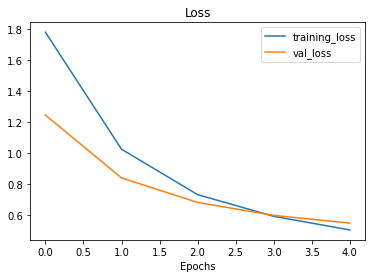

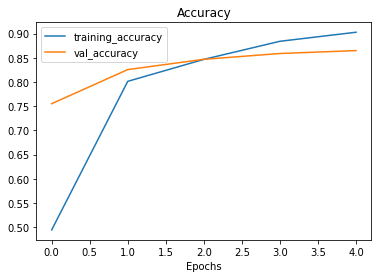

In [21]:
plot_loss_curves(efficientnet_history)

We can see from the model fit output that te EfficientNetB0 performs even better than the ResNetV250, with over 85% accuracy on the training set (with 10% of the data from our original mode!).

We can also see from the loss curves that the training and validation loss and accuracy curves stay closer together. Additionally, we see that the val_accuracy has a positive slope to it. Perhaps we can train longer for better results?

In [22]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


Despite having >4x fewer parameters it perfoms better. "Efficient"

## Comparing models using TensorBoard
Above we compared the two models the traditional way, but when we have more models it becomes difficult. Let's leverage TensorBoard to do this work..

To visualize our callback results we can upload them to [TensorBoard.dev](https://tensorboard.dev/).

Note: If uploaded, these experiments are then public, so do not upload sensitive data. Models can be deleted. 

### Uploading experiments to TensorBoard

Experiments can be uploaded with the following command
```
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  -- name "EfficientNetB0 vs ResNet50V2" \
  -- description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot
```

Where:
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is a brief description
* `--one_shot` exits the TensorBoard uploaded once done.

In [23]:
# Let's upload!
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Lr4QCojkmnSuEMOld4qN0GNl3ypqy2&prompt=consent&access_type=off

In [24]:
# What experiments were uploaded?
!tensorboard dev list

https://tensorboard.dev/experiment/opcxxULGR5O9JNaA0NuoTw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   opcxxULGR5O9JNaA0NuoTw
	Created              2022-06-28 17:44:26 (1 minute ago)
	Updated              2022-06-28 17:44:29 (1 minute ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  10000626
Total: 1 experiment(s)


### Deleting experiments from TensorBoard

In [26]:
# Let's remove it
!tensorboard dev delete --experiment_id opcxxULGR5O9JNaA0NuoTw

Deleted experiment opcxxULGR5O9JNaA0NuoTw.


In [27]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
